In [2]:
%run setup.py

# Read in Kepler sample

In [3]:
stars = pd.read_excel(work_dir+'sample/clumps.xlsx')

## Define useful selections

In [5]:
# Select all very-low-mass HeB stars
lidx = (stars['Phase']==2) & (stars['ifclump']==1) & (np.abs(stars['dist_mass_sig'])>1)

# Select all under-luminous HeB stars
uidx = (stars['Phase']==2) & (stars['ifclump']==2) & (np.abs(stars['dist_nike_sig'])>1)

# Select regular stars
oidx = (stars['Phase']==2) & (stars['ifclump']!=-1) & (~lidx) & (~uidx)

# all stars
heb = lidx | uidx | oidx

print('very-low-mass stars', np.sum(lidx))
print('under-luminous stars', np.sum(uidx))
print('regular stars', np.sum(oidx))
print('all HeB stars', np.sum(heb))
print('all HeB stars with APOGEE/LAMOST metallicity', np.sum(heb&np.isfinite(stars['[M/H]'])))

very-low-mass stars 32
under-luminous stars 7
regular stars 7499
all HeB stars 7538
all HeB stars with APOGEE/LAMOST metallicity 6612


# Read in evolutionary tracks

In [11]:
class readTable:
    '''
    A parent class to be wrapped by other class, in order to read in such as mesa history file.
    These files have very similar structures, typically header+table.

    '''
    def __init__(self, filepath, verbose=True):
        '''
        Args:
            filepath: the path of .history file.
            verbose: whether print info to device. default: True.

        Attributes:
            header: a dictionary containing history file header
            track: a structure numpy array containing the evol track
            colnames: a tuple containing column names

        '''  
        self.filepath = filepath
        if verbose: 
            print('Processing :', self.filepath)
        return
    
    def readFile(self, filepath, headerNameLine=1, headerDataLine=2, tableHeaderLine=6):
        '''
        Reads in a file.
        '''

        with open(self.filepath) as f:
            content = [line.split() for line in f]
        header = {content[headerNameLine-1][i]:content[headerDataLine-1][i] for i in range(len(content[headerNameLine-1]))}
        table = np.genfromtxt(self.filepath, skip_header=tableHeaderLine-1, names=True)
        colnames = table.dtype.names

        return header, table, colnames


class history(readTable):
    '''

    A class to read mesa history files, store the data within, and offer useful routines (?).

    '''
    
    def __init__(self, filepath, verbose=True, ifReadProfileIndex=False):
        '''
        Args:
            filepath: the path of .history file.
            verbose: whether print info to device. default: True.

        Attributes:
            header: a dictionary containing history file header
            track: a structure numpy array containing the evol track
            colnames: a tuple containing column names
            profileIndex: a structured array containing the map between model_number and profile_number

        '''
        super().__init__(filepath, verbose)
        self.header, self.track, self.colnames = self.readFile(filepath, headerNameLine=2, headerDataLine=3, tableHeaderLine=6)
        
        if ifReadProfileIndex:
            self.profileIndex = self.read_profile_index()
        return
    
    def read_profile_index(self):
        '''
        Reads in the profile.index file
        '''
        filepath = self.filepath.split('.history')[0] + 'profile.index'
        profileIndex = np.genfromtxt(filepath, skip_header=1, names=('model_number', 'priority', 'profile_number'))
        return profileIndex


class profile(readTable):
    '''

    A class to read mesa history files, store the data within, and offer useful routines.

    '''

    
    def __init__(self, filepath, verbose=True):
        '''
        Args:
            filepath: the path of *profile*.data file.
            verbose: whether print info to device. default: True.

        Attributes:
            header: a dictionary containing history file header
            profile: a structure numpy array containing the structure profile
            colnames: a tuple containing column names

        '''
        super().__init__(filepath, verbose)
        self.header, self.profile, self.colnames = self.readFile(filepath, headerNameLine=2, headerDataLine=3, tableHeaderLine=6)

        return

In [12]:
Nmodels = 8+8+5
filepaths = [work_dir+'modelling/coarse_v0']*8 + [work_dir+'modelling/coarse_v1']*8  + [work_dir+'modelling/coarse_v1']*5
indexes = [4,1,9,10,11,12,13,14, #0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0
           5,1,15,17,19,20,21,22,
           4,0,14,16,18]
models = [[] for i in range(Nmodels)]

for ihist in range(Nmodels):
    hist = history(filepaths[ihist]+'/heb/history/index{:06.0f}.history'.format(indexes[ihist]), ifReadProfileIndex=False)
    model = pd.DataFrame(hist.track)
    
    model['Dnu_scaling'] = (model['star_mass'])**0.5 * (10.0**model['log_R'])**-1.5 * 135.1
    model['numax'] = (model['star_mass'])**1.0 * (10.0**model['log_R'])**-2.0 * (10.0**model['log_Teff']/5777)**-0.5 * 3090.
    
    model['index'] = indexes[ihist]
    
    models[ihist] = model

Processing : ../modelling/coarse_v0/heb/history/index000004.history
Processing : ../modelling/coarse_v0/heb/history/index000001.history
Processing : ../modelling/coarse_v0/heb/history/index000009.history
Processing : ../modelling/coarse_v0/heb/history/index000010.history
Processing : ../modelling/coarse_v0/heb/history/index000011.history
Processing : ../modelling/coarse_v0/heb/history/index000012.history
Processing : ../modelling/coarse_v0/heb/history/index000013.history
Processing : ../modelling/coarse_v0/heb/history/index000014.history
Processing : ../modelling/coarse_v1/heb/history/index000005.history
Processing : ../modelling/coarse_v1/heb/history/index000001.history
Processing : ../modelling/coarse_v1/heb/history/index000015.history
Processing : ../modelling/coarse_v1/heb/history/index000017.history
Processing : ../modelling/coarse_v1/heb/history/index000019.history
Processing : ../modelling/coarse_v1/heb/history/index000020.history
Processing : ../modelling/coarse_v1/heb/history/

In [14]:
# No mass loss, M_init= 2.2 Msun, M_init = 1.5 Msun
models1, models2, models3 = models[0:8], models[8:16], models[16:]

# Define the observed (Kepler) ZAHeB edge

In [15]:
import scipy

points=[(40., 2.7), (31.5, 2.95), (31.9, 3.2), (34.8, 3.36), (38, 3.47), (56, 3.74), (98, 3.84), (110, 3.85)] #(32, 2.9), (30.7, 3.0), 
yedge = np.arange(2.7, 3.85, 0.0001)
Npoint = len(points)
xpoint, ypoint = np.array([points[i][0] for i in range(Npoint)]), np.array([points[i][1] for i in range(Npoint)])
tck = scipy.interpolate.splrep(np.log10(ypoint), np.log10(xpoint), s=0)
# tp = (110, 3.85)
xedge = 10.0**scipy.interpolate.splev(np.log10(yedge), tck)

# Plot Figure 1

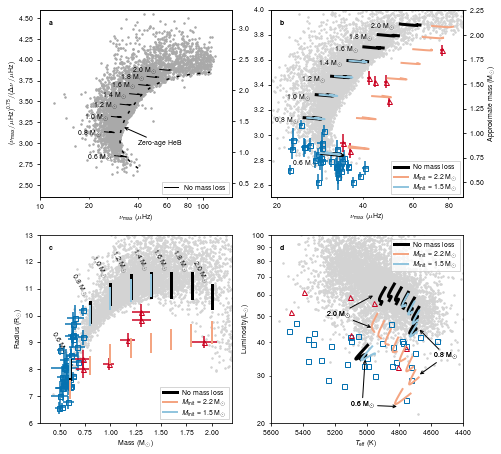

In [16]:
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

gridspec_kw = {'left':0.09, 'right':0.92, 'top':0.98, 'bottom':0.08, 'wspace':0.2, 'hspace':0.2}
fig, axes = plt.subplots(figsize=nature_size('double', ratio=0.9), nrows=2, ncols=2, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)


style = {'marker':'.', 'color':'lightgrey', 'ms':3, 'zorder':-10, 'linestyle':'none', 'rasterized':True}
style0 = {'marker':'.', 'color':darkgrey, 'ms':3, 'zorder':-10, 'linestyle':'none', 'rasterized':True}
ustyle = {'marker':'^', 'mec':red, 'ecolor':red, 'mfc':'none', 'ms':5, 'zorder':2, 'linestyle':'none'}
lstyle = {'marker':'s', 'mec':blue, 'ecolor':blue, 'mfc':'none', 'ms':5, 'zorder':1, 'linestyle':'none'}
cstyle = {'marker':'o', 'mec':'purple', 'mfc':'none', 'ms':5, 'zorder':1, 'linestyle':'none'}

# Nike diagram
axes[0].errorbar(stars.loc[heb,'numax'], stars.loc[heb,'nike'], **style0)
axes[0].plot(xedge, yedge, linestyle=(0,(2,5)), color='k')
axes[0].set_xscale('log',subs=[0,2,4,6,8,])
axes[0].set_xlim(10,150)
axes[0].set_ylim(2.35,4.6)
axes[0].get_xaxis().set_major_formatter(ScalarFormatter())
axes[0].get_xaxis().set_minor_formatter(ScalarFormatter())
axes[0].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')
axes[0].set_ylabel('$(\\nu_{\\rm max}/\\mu{\\rm Hz})^{0.75}/(\\Delta\\nu/\\mu{\\rm Hz})$')

twax = axes[0].twinx()
twax.set_ylim((np.array([2.35,4.4])/3090**0.75*135.1/((4900/5777.)**-0.375))**4.)


# Zoom in Nike diagram
axes[1].errorbar(stars.loc[oidx,'numax'], stars.loc[oidx,'nike'], **style)
axes[1].errorbar(stars.loc[uidx,'numax'], stars.loc[uidx,'nike'], 
                 xerr=stars.loc[uidx,'e_numax'], yerr=stars.loc[uidx,'e_nike'], **ustyle)
axes[1].errorbar(stars.loc[lidx,'numax'], stars.loc[lidx,'nike'], 
                 xerr=stars.loc[lidx,'e_numax'], yerr=stars.loc[lidx,'e_nike'], **lstyle)
axes[1].set_xscale('log',subs=[0,2,4,6,8,])
axes[1].set_xlim(19,90)
axes[1].set_ylim(2.5,4.0)
axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
axes[1].get_xaxis().set_minor_formatter(ScalarFormatter())
axes[1].set_xlabel('$\\nu_{\\rm max}$ ($\\mu$Hz)')

twax = axes[1].twinx()
twax.set_ylim((np.array([2.5,4.0])/3090**0.75*135.1/((4900/5777.)**-0.375))**4.)
twax.set_ylabel('Approximate mass (M$_{\\odot}$)')


# mass radius diagram
axes[2].errorbar(stars.loc[oidx,'mass'], stars.loc[oidx,'radius'], **style)
axes[2].errorbar(stars.loc[uidx,'mass'], stars.loc[uidx,'radius'], 
                 xerr=stars.loc[uidx,'e_mass'], yerr=stars.loc[uidx,'e_radius'],  **ustyle)
axes[2].errorbar(stars.loc[lidx,'mass'], stars.loc[lidx,'radius'], 
                 xerr=stars.loc[lidx,'e_mass'], yerr=stars.loc[lidx,'e_radius'],  **lstyle)
axes[2].set_xlim(0.3, 2.2)
axes[2].set_ylim(6.0, 13.0)
axes[2].set_xlabel('Mass (M$_{\\odot}$)')
axes[2].set_ylabel('Radius (R$_{\\odot}$)')


# HR diagram
axes[3].errorbar(stars.loc[oidx,'Teff'], stars.loc[oidx,'lum'], **style)
axes[3].errorbar(stars.loc[uidx,'Teff'], stars.loc[uidx,'lum'], **ustyle)
axes[3].errorbar(stars.loc[lidx,'Teff'], stars.loc[lidx,'lum'], **lstyle)

axes[3].set_yscale('log')
axes[3].set_xlim(5600,4400)
axes[3].set_ylim(20, 100)
axes[3].set_xlabel('$T_{\\rm eff}$ (K)')
axes[3].set_ylabel('Luminosity (L$_{\\odot}$)')
axes[3].set_yscale('log')
axes[3].get_yaxis().set_major_formatter(ScalarFormatter())
axes[3].get_yaxis().set_minor_formatter(ScalarFormatter())


for model in models1:
    midx = (model['center_he4']>0.1) & (model['center_he4']<0.93)
    modelstyles = {'c':black, 'linestyle':'-', 'zorder':10, 'linewidth':3}
    modelstyles0 = {'c':black, 'linestyle':'-', 'zorder':10, 'linewidth':1}
    axes[0].plot(model.loc[midx,'numax'], model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'], **modelstyles0)
    axes[0].text(np.min(model.loc[midx,'numax'])*0.95, 
                 np.min(model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'])-0.025,
                 '{:0.1f}'.format(np.median(model.loc[midx,'star_mass']))+' M$_{\\odot}$', fontsize=fontsize, ha='right')
    
    axes[1].plot(model.loc[midx,'numax'], model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'], **modelstyles)
    if (np.abs(np.median(model.loc[midx,'star_mass'])-0.6)<0.02) : # 0.6Msun
        axes[1].text(np.min(model.loc[midx,'numax'])*0.95, 
                     np.min(model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'])-0.080,
                     '{:0.1f}'.format(np.median(model.loc[midx,'star_mass']))+' M$_{\\odot}$', fontsize=fontsize, ha='right')
    else: # other models
        axes[1].text(np.min(model.loc[midx,'numax'])*0.95, 
                     np.min(model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'])-0.025,
                     '{:0.1f}'.format(np.median(model.loc[midx,'star_mass']))+' M$_{\\odot}$', fontsize=fontsize, ha='right')
    axes[2].plot(model.loc[midx,'star_mass'], 10.0**model.loc[midx,'log_R'], **modelstyles)
    axes[2].text(np.max(model.loc[midx,'star_mass'])-0.02, 
                 np.min(10.0**model.loc[midx,'log_R'])+1.0,
                 '{:0.1f}'.format(np.median(model.loc[midx,'star_mass']))+' M$_{\\odot}$', fontsize=fontsize, rotation=270+30, ha='right')    

    axes[3].plot(10.0**model.loc[midx,'log_Teff'], 10.0**model.loc[midx,'log_L'], **modelstyles)

axes[0].plot([1e10,1e10],[1e10,1e10], label='No mass loss', **modelstyles0)
axes[1].plot([1e10,1e10],[1e10,1e10], label='No mass loss', **modelstyles)
axes[2].plot([1e10,1e10],[1e10,1e10], label='No mass loss', **modelstyles)
axes[3].plot([1e10,1e10],[1e10,1e10], label='No mass loss', **modelstyles)

for model in models2:
    midx = (model['center_he4']>0.1) & (model['center_he4']<0.88)
    modelstyles = {'c':lightred, 'linestyle':'-', 'zorder':10, 'linewidth':2}
    axes[1].plot(model.loc[midx,'numax'], model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'], **modelstyles)
    axes[2].plot(model.loc[midx,'star_mass'], 10.0**model.loc[midx,'log_R'], **modelstyles)
    axes[3].plot(10.0**model.loc[midx,'log_Teff'], 10.0**model.loc[midx,'log_L'], **modelstyles)


axes[1].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 2.2 M$_{\\odot}$', **modelstyles)
axes[2].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 2.2 M$_{\\odot}$', **modelstyles)
axes[3].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 2.2 M$_{\\odot}$', **modelstyles)

arrowprops = {'width':10, 'headwidth':10, 'headlength':10}
arrowprops = {'arrowstyle':'->'}

# (arrow coord), (text coord)
axes[0].annotate('Zero-age HeB', (32.,3.2), (40,3.0),  fontsize=fontsize, va='center', arrowprops=arrowprops)

axes[3].annotate('0.6 M$_{\\odot}$', (5010,35), (5100,23), fontsize=fontsize, arrowprops=arrowprops)
axes[3].annotate('0.6 M$_{\\odot}$', (4800,23), (5100,23), fontsize=fontsize, arrowprops=arrowprops)

axes[3].annotate('0.8 M$_{\\odot}$', (4680,30), (4580,35), fontsize=fontsize, arrowprops=arrowprops)
axes[3].annotate('0.8 M$_{\\odot}$', (4680,45), (4580,35), fontsize=fontsize, arrowprops=arrowprops)

axes[3].annotate('2.0 M$_{\\odot}$', (4950,60), (5250,50), fontsize=fontsize, arrowprops=arrowprops)
axes[3].annotate('2.0 M$_{\\odot}$', (4960,45), (5250,50), fontsize=fontsize, arrowprops=arrowprops)


for model in models3:
    midx = (model['center_he4']>0.1) & (model['center_he4']<0.88)
    modelstyles = {'c':lightblue, 'linestyle':'-', 'zorder':10, 'linewidth':2}
    axes[1].plot(model.loc[midx,'numax'], model.loc[midx,'numax']**0.75/model.loc[midx,'Dnu_scaling'], **modelstyles)
    axes[2].plot(model.loc[midx,'star_mass'], 10.0**model.loc[midx,'log_R'], **modelstyles)
    axes[3].plot(10.0**model.loc[midx,'log_Teff'], 10.0**model.loc[midx,'log_L'], **modelstyles)
    

axes[1].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 1.5 M$_{\\odot}$', **modelstyles)
axes[2].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 1.5 M$_{\\odot}$', **modelstyles)
axes[3].plot([1e10,1e10],[1e10,1e10], label='$M_{\\rm init}$ = 1.5 M$_{\\odot}$', **modelstyles)


labels = ['{\\textbf{a}}', '{\\textbf{b}}', '{\\textbf{c}}', '{\\textbf{d}}']
for iax, ax in enumerate(axes):
    ax.text(0.05, 0.92, labels[iax], transform=ax.transAxes, fontsize=fontsize)
    if iax==3:
        ax.legend(loc='upper right', fancybox=False, fontsize=fontsize)
    else:
        ax.legend(loc='lower right', fancybox=False, fontsize=fontsize)

plt.savefig(overleaf_path+'Fig_main_1_nike_diagram.pdf')